In [1]:
# -*- coding: utf-8 -*- 
# This code is written in Python 3.7. To install the required packages, run the following commands:
# pip install pandas numpy matplotlib seaborn scikit-learn sympy
# This code is applicable to the N_BaIoT dataset. 

# implemented Logistic Regression Classifier.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import tensorflow as tf
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt

2024-05-27 22:20:47.328953: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-27 22:20:47.367312: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 22:20:48.036294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

df = pd.read_csv('/home/ibibers@ads.iu.edu/IOT_Datasets/device7.csv')

# Drop duplicates
df = df.drop_duplicates(keep='first')

# Drop columns that have just one unique value
one_value = df.columns[df.nunique() == 1]
df = df.drop(columns = one_value, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115936 entries, 0 to 119999
Columns: 116 entries, MI_dir_L5_weight to label
dtypes: float64(115), int64(1)
memory usage: 103.5 MB


In [3]:
# X-axis: Represents acceleration along the horizontal axis.
# Y-axis: Represents acceleration along the vertical axis.
# Z-axis: Represents acceleration along the depth axis.

# labels 
#1. Normal: This label represents the state of the machine when it is operating under normal conditions, without any significant mechanical imbalance or impending failure.
#2. Near-failure: This label indicates that the machine is experiencing conditions that suggest it is close to a failure state. These conditions may include early signs of mechanical imbalance or other issues that could lead to failure if not addressed.
#3. Failure: This label is assigned when the machine has reached a state of failure, where it is no longer functioning as intended due to mechanical issues or other problems.


# Extract subsample of data
print (" Extract subsample of data: ")
print(df['label'].value_counts())

 Extract subsample of data: 
label
4    20000
3    20000
6    20000
1    19623
5    18157
2    18156
Name: count, dtype: int64


In [4]:
dropped_df = ['label']
X = df.drop(dropped_df, axis=1)
y = df['label']

In [5]:
start_time = time.time()
# Initial train test split set and split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize MirroredStrategy for GPU acceleration
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Initialize the LogisticRegression
    lr_model = LogisticRegression()

    start_train_time = time.time()
    # Train the model
    lr_model.fit(X_train, y_train)
    train_time = time.time() - start_train_time
    
    start_pred_time = time.time()  
    # Make predictions
    y_pred_encoded = lr_model.predict(X_test)
    pred_time = time.time() - start_pred_time

total_time = time.time() - start_time

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2024-05-27 22:20:51.176636: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ibibers@ads.iu.edu/micromamba/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
print("Time taken for training:{:f} seconds".format(train_time))
print("Time taken for prediction: {:f} seconds".format(pred_time))
print("Total time taken:{:f} seconds".format(total_time))

Time taken for training:5.344654 seconds
Time taken for prediction: 0.009881 seconds
Total time taken:5.535964 seconds


In [7]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_encoded)
print(f"Accuracy: {accuracy}")

Accuracy: 0.34415341709554065


In [8]:
#  Classificaiton Report 
print("\nClassification Report:")
print(classification_report(y_test, y_pred_encoded))


Classification Report:
              precision    recall  f1-score   support

           1       0.26      0.46      0.33      5887
           2       0.40      1.00      0.57      5447
           3       0.00      0.00      0.00      6000
           4       0.39      0.63      0.48      6000
           5       0.00      0.00      0.00      5447
           6       0.00      0.00      0.00      6000

    accuracy                           0.34     34781
   macro avg       0.17      0.35      0.23     34781
weighted avg       0.17      0.34      0.23     34781



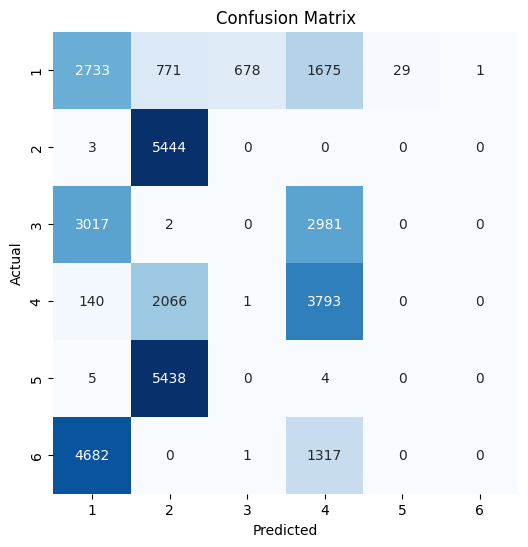

In [9]:
# Confusion matrix with string labels
conf_mat = confusion_matrix(y_test, y_pred_encoded)

# Get unique class labels from y_test and y_pred_encoded
unique_labels = np.unique(np.concatenate((y_test, y_pred_encoded)))

# Plotting the Confusion Matrix with class labels
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/tmp/ipykernel_1161410/1465386185.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_importance.values()), y=list(


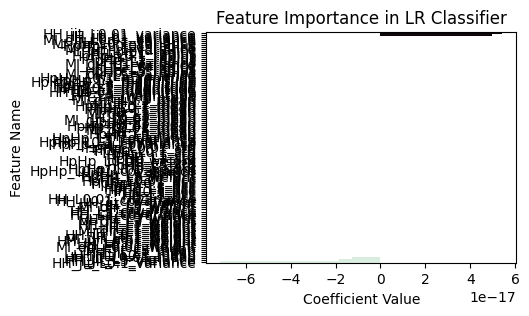

In [10]:
# Feature Importance
# Extracting the coefficients for the first class (assuming binary classification)
importance = lr_model.coef_[0]
importance_dict = dict(zip(X.columns.values, importance))
sorted_importance = dict(
    sorted(importance_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(4, 3))
sns.barplot(x=list(sorted_importance.values()), y=list(
    sorted_importance.keys()), palette='mako')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance in LR Classifier')
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_encoded)
precision = precision_score(y_test, y_pred_encoded, average='macro')
recall = recall_score(y_test, y_pred_encoded, average='macro')
f1 = f1_score(y_test, y_pred_encoded, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_encoded)

# Print evaluation metrics
print("Prediction Evaluation:")
print("Accuracy: {:f}".format(accuracy))
print("Precision: {:f}".format(precision))
print("Recall: {:f}".format(recall))
print("F1-score: {:f}".format(f1))
print("Confusion Matrix:")
print(conf_matrix)


Prediction Evaluation:
Accuracy: 0.344153
Precision: 0.173885
Recall: 0.349310
F1-score: 0.230168
Confusion Matrix:
[[2733  771  678 1675   29    1]
 [   3 5444    0    0    0    0]
 [3017    2    0 2981    0    0]
 [ 140 2066    1 3793    0    0]
 [   5 5438    0    4    0    0]
 [4682    0    1 1317    0    0]]
